In [661]:

# Importing necessary libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.special as sp
from scipy.special import loggamma
from scipy.stats import beta, binom, norm, uniform
import csv

In [662]:
# Get the data
df_all_skateboarders = pd.read_csv("Datafil.csv")

contestants = [
    "Majerus", "Oliveira", "Decenzo", "Santiago",
    "Papa", "Eaton", "Mota", "Shirai",
    "Jordan", "Hoefler", "Hoban", "Gustavo",
    "Ribeiro C", "O’neill", "Foy", "Midler"
]

df = df_all_skateboarders[df_all_skateboarders['id'].isin(contestants)]
# Uncomment to see the dataframe
# print(df)

# 1 Warm-up
The following tasks are designed to familiarize you with the dataset and prepare the data for use when building your predictive models.

### (a) 
All scores in the dataframe are currently numbers between 0 and 10. Normalize these values in the dataframe so that they range between 0 and 1.

In [663]:
for col in df.columns[5:]:
    df.loc[:, col] = df[col].apply(lambda x: x/10 if x == x else x)  # handle NaN values
    
#Using .loc ensures that we are modifying the original DataFrame instead of creating a view or copy of it

C:\Users\villi\AppData\Local\Temp\ipykernel_12344\1060903183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].apply(lambda x: x/10 if x == x else x)  # handle NaN values


### (b) 
Create a histogram for all trick scores for tricks 1-4. 
- What do you observe? 
- Is there a particular value that appears more often than the others? 
- If so, how does this value compare to the others?

In [664]:
# b) here i create a histogram fr normalized data
def plot_histograms(datafile):
    # List of tricks
    tricks = ["trick 1", "trick 2", "trick 3", "trick 4"]

    # Plot histograms for each trick
    for idx, trick in enumerate(tricks, 1):
        plt.subplot(2, 2, idx)  # 2x2 grid of histograms
        plt.hist(df[trick].dropna(), bins=20, alpha=0.7, color='blue')  # dropna() ensures NaN values are ignored
        plt.title(f"Histogram of {trick}")
        plt.xlabel("Score")
        plt.ylabel("Frequency")

    # Adjust layout to prevent overlaps and show the plot
    plt.tight_layout()
    plt.show()

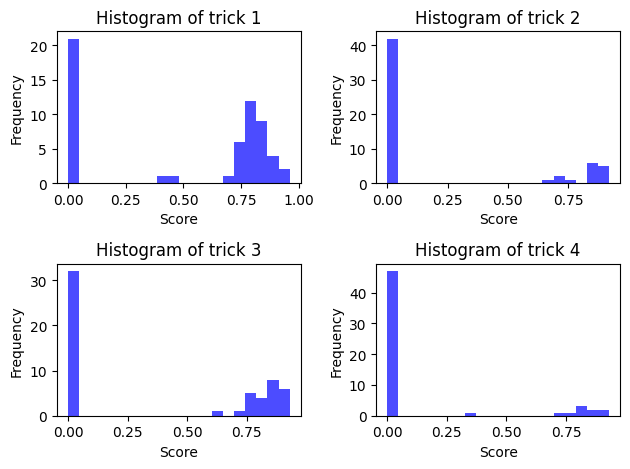

In [665]:
plot_histograms(df)

*From our observations, the most common score for each trick is zero, by a significant margin. The majority of other scores fall within the 0.6 to 0.9 range, with a noticeable lack of scores between 0 and 0.6. This pattern suggests that contestants tend to attempt more challenging tricks, which typically result in either failure (yielding a score of zero) or a relatively high score. This behavior indicates a tendency to bypass tricks of easy to medium difficulty.*

### (c)
- For each trick (1-4), create a new column named 'make i' for $i=1,2,3,4$. 
- The value of 'make i' in a given row should be 1 if the skateboarder successfully landed trick $i$ and 0 otherwise.

In [ ]:
for i in range(1, 5):
    trick_column = f"trick {i}"
    
    # Assuming a trick is executed if its score > 0
    df.loc[:, f"make {i}"] = df.loc[:, trick_column].apply(lambda x: 1 if x > 0 else 0)

### (d)
For each skateboarder, estimate the probability that a trick receives a score greater than 0.6, given that the skateboarder successfully lands the trick. 
- What is the probability that the skateboarder fails to land a particular trick? 
- What observations can you make? Relate your findings to your observations in part (b).

In [667]:

def estimate_probabilities(df):

    grouped_df = df.groupby('id')
    results = []

    for name, group in grouped_df:

        successful_tricks = group[[f"trick {i}" for i in range(1, 6)]].applymap(lambda x: 1 if x > 0 else 0).sum().sum()
        
        # Probability that a trick receives a score greater than 0.6 given the trick was landed
        tricks_score_more_than_06 = group[[f"trick {i}" for i in range(1, 6)]].applymap(lambda x: 1 if x >= 0.6 else 0).sum().sum()

        # Probability that a trick receives a score greater than 0.6 given the trick was landed
        prob_success_given_landed = tricks_score_more_than_06 / successful_tricks if successful_tricks > 0 else 0
        
        # Probability that the skateboarder fails to land a trick
        total_tricks = group[[f"trick {i}" for i in range(1, 6)]].count().sum()
        failed_tricks = group[[f"trick {i}" for i in range(1, 6)]].applymap(lambda x: 1 if x == 0 else 0).sum().sum()
        prob_failure = failed_tricks / total_tricks
        
        results.append((name, prob_success_given_landed, prob_failure))
    
    # Uncoment to see the results
    #for name, success_given_landed, failure in results:
    #    print(f"Skateboarder {name}: P(Score > 0.6 | Landed) = {success_given_landed:.2f}, P(Failure) = {failure:.2f}")

In [668]:
#Please note that this is for all tricks!
estimate_probabilities(df)

**Here, I will add a modified version of this code that handles each trick separately!**

In [669]:
def estimate_probabilities_by_individual_trick(df):
    # Group by skateboarder's name to get each skateboarder's data across all locations
    grouped_df = df.groupby('id')

    results = []

    for name, group in grouped_df:
        for i in range(1, 6):  # Iterate through each trick
            trick_col = f"trick {i}"

            # Number of times this specific trick was landed by the skateboarder across all locations
            successful_tricks = group[trick_col].apply(lambda x: 1 if x > 0 else 0).sum()

            # Number of times this specific trick got a score >= 0.6 by the skateboarder across all locations
            tricks_score_more_than_06 = group[trick_col].apply(lambda x: 1 if x >= 0.6 else 0).sum()

            # Probability that this trick receives a score greater than 0.6 given the trick was landed
            prob_success_given_landed = tricks_score_more_than_06 / successful_tricks if successful_tricks > 0 else 0

            # Total attempts of this specific trick by the skateboarder across all locations
            total_tricks = group[trick_col].count()

            # Number of times this specific trick failed (scored 0) by the skateboarder across all locations
            failed_tricks = group[trick_col].apply(lambda x: 1 if x == 0 else 0).sum()

            # Probability that the skateboarder fails to land this trick
            prob_failure = failed_tricks / total_tricks if total_tricks > 0 else 0

            results.append((name, trick_col, prob_success_given_landed, prob_failure))
            
    # Uncomment to see the results
    # for name, trick, success_given_landed, failure in results:
    #     print(f"Skateboarder {name} for {trick}: P(Score > 0.6 | Landed) = {success_given_landed:.2f}, P(Failure) = {failure:.2f}")

In [670]:
estimate_probabilities_by_individual_trick(df)

### (e) 
Create a scatter plot for run score 1 versus run score 2. 

- Do you see any clear correlation from the diagram?

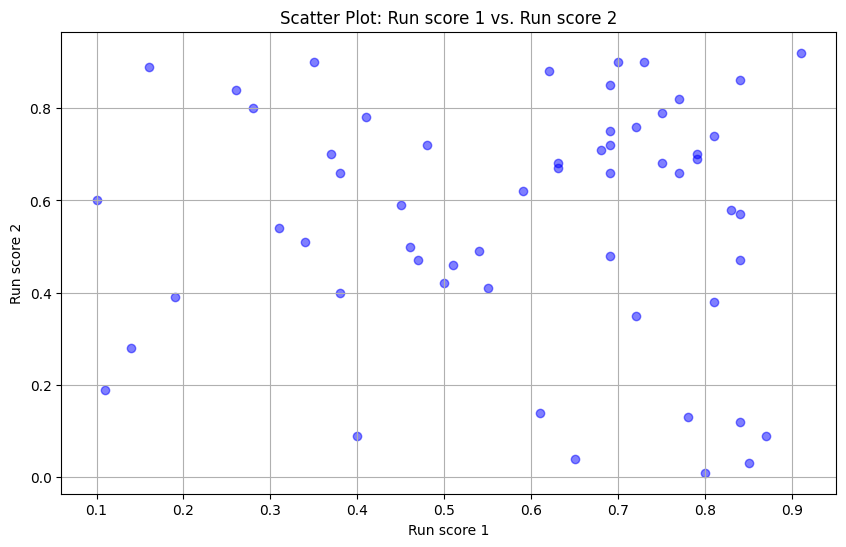

In [671]:
# Extracting data for plotting
x = df['run 1']
y = df['run 2']

# Creating the scatter plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='blue', alpha=0.5)
plt.title('Scatter Plot: Run score 1 vs. Run score 2')
plt.xlabel('Run score 1')
plt.ylabel('Run score 2')
plt.grid(True)

# Display the plot
plt.show()

# 2. A Frequentist Model

## Problem Statment

We'd like to construct a model that can predict which of the 16 skateboarders in the LCQ will secure a spot in the final. 

One approach to this is to construct a model for each skateboarder, utilize these models to simulate run scores and trick scores for every skateboarder, and then combine these simulations to simulate the LCQ as a whole. 

By simulating multiple LCQs, we can extract the top four skateboarders with the highest cumulative scores from each. 
Our prediction would then be the mode of these outcomes. 

**NOTE:** *Please note that this model assumes that the performances of the skateboarders are independent. For the sake of simplicity, we'll assume that the score for a particular run $Y_i$ and the score for a specific trick $X_i$ are independent for each skateboarder.*

- For skateboarder $i$, we assume that all trick scores and run scores are independent and have identically distributed outcomes from $X_i$ and $Y_i$ respectively. 

- We can start by specifying a model for $X_i$ and $Y_i$. 

---

From the observations in Task 1, a plausible model for $X_i$ is the following:
$$
X_i = 
\begin{cases} 
0 & \text{if } V_i = 0, \\ 
Z_i & \text{if } V_i = 1,
\end{cases}
$$
where 
$$ V_i \sim \text{Ber}(\theta_i), $$
$$ Z_i \sim \text{Beta}(\alpha_i, \beta_i) $$
and 
$$ V_i \perp Z_i. $$
It can be shown that
$$ 
f_{X_i}(x_i | \theta_i, \alpha_i, \beta_i) = (1-\theta_i) \mathbb{1}_{\{x_i=0\}} + \theta_i f_{Z_i}(z_i).
$$
The choice $ V_i \sim \text{Ber}(\theta_i) $ models the fact that a skateboarder receives a score of 0 if and only if they do not successfully land the trick. Meanwhile, the choice $ Z_i \sim \text{Beta}(\alpha_i, \beta_i) $ models that the score for a particular trick represents the portion of the trick that was "perfect."

## (a) Provide a point estimate for each $\theta_i$

### ANALYTICAL ANSWER:

https://en.wikipedia.org/wiki/Bernoulli_distribution

---



We can attempt a ML point estimation for $\theta_i$ since we know that $V_i$ follows a Bernoulli distribution with parameter $\theta_i$.

$$ V_i \sim \text{Ber}(\theta_i) $$
$$
f_{V_i}\left(\theta_i\right)=\theta_i^{v_i}\left(1-\theta_i\right)^{1-v_1}
$$

*Note: Parameter $\theta_i$ for $\text{Ber}(\theta_i)$ has to be $\theta_i \in[0,1]$ we lake this since we normalized the scores.*

$$
\log L\left(\theta \mid v_j\right)=\log \prod_i^n \theta_i^{v_i}(1-\theta_i)^{1-v_i}=
$$
$$
=\sum_{k=1}^n \log \theta_i^{v_k}(1-\theta_i)^{1-x_k}=\sum_{k=1}^n \log \theta_i^{v_k}+\sum_{k=1}^n \log \left(1-\theta_i\right)^{1-v_k}=
$$
$$
=\log \theta_i \cdot \sum_{k=1} V_k+\log \left(1-\theta_i\right) \sum\left(1-V_k\right)
$$

*We can now attmpt to take a derivative.*

$$
L^{\prime}\left(\theta_i \mid v\right)=\frac{\sum V_k}{\theta_i}-\frac{1}{1-\theta_i}\sum_{k=1}^n\left(1-v_k\right)=\frac{\sum_{k=1}^n v_k}{\theta_i}-\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}
$$

*To find the critical point we set $L^{\prime}\left(\theta_i \mid v\right)=0$*
$$
\frac{\sum_{k=1}^n v_k}{\theta_i}-\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}=0
$$

$$
\frac{\sum_{k=1}^n v_k}{\theta_i}-\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}=0
$$

$$
\frac{\sum_{k=1}^n v_k}{\theta_i}=\frac{\left(n-\sum_{k=1}^n v_k\right)}{1-\theta_i}
$$

$$
\sum_{k=1}^n v_k-\theta_i \sum_{k=1}^n v_k=\theta_i n-\theta_i\sum_{k=1}^nv_k
$$

$$
\sum_{k=1}^n v_k=\theta_i n
$$

$$
\theta_i=\frac{\sum_{k=1}^n v_k}{n}
$$

***We can see that this is just a sample mean.***

---

###  CODE:

***Calculating $\theta_i$ for each  at each location:***

In [672]:
# Extracting data and calculating the mean for each skateboarder at each location.
make_columns = ['make 1', 'make 2', 'make 3', 'make 4']

df['total_made'] = df[make_columns].sum(axis=1)
df['total_attempted'] = df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].notna().sum(axis=1)
df['theta_i'] = df['total_made'] / df['total_attempted']

# Uncoment to see the results.
#print(df[['id', 'theta_i']])

C:\Users\villi\AppData\Local\Temp\ipykernel_12344\2283347732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_made'] = df[make_columns].sum(axis=1)
C:\Users\villi\AppData\Local\Temp\ipykernel_12344\2283347732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_attempted'] = df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].notna().sum(axis=1)
C:\Users\villi\AppData\Local\Temp\ipykernel_12344\2283347732.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

***Calculating colective $\theta_i$ for each skateboarder:***

In [673]:
# Group by 'id' and compute the mean of theta_i for each skateboarder
theta_average = df.groupby('id')['theta_i'].mean().reset_index()

# Rename the columns for clarity
theta_average.columns = ['id', 'theta_average']

#Okay, that's great! 
# Now I have this information, but I would like to save it into the main DataFrame file.
# Merge the theta_average DataFrame with the original df on 'id'
df = df.merge(theta_average, on='id', how='left')

# Uncoment to see the results.
#print(theta_average)


***Creating results_df***

In [674]:
# Round all float columns to 5 decimal places
df = df.round(5)
results_df = theta_average[['id', 'theta_average']]

print(results_df)

           id  theta_average
0     Decenzo       0.437500
1       Eaton       0.625000
2         Foy       0.500000
3     Gustavo       0.400000
4       Hoban       0.400000
5     Hoefler       0.437500
6      Jordan       0.400000
7     Majerus       0.375000
8      Midler       0.333333
9        Mota       0.250000
10   Oliveira       0.416667
11    O’neill       0.250000
12       Papa       0.437500
13  Ribeiro C       0.250000
14   Santiago       0.083333
15     Shirai       0.400000


## (b) Provide a point estimate for the parameters $\left[\alpha_i, \beta_i\right]^{\mathrm{T}}$ for each skateboarder $i$. 

### ANALYTICAL ANSWER:

https://en.wikipedia.org/wiki/Gamma_distribution

https://en.wikipedia.org/wiki/Beta_distribution

---

For the Beta distribution:
$$
f\left(z_i \mid \alpha_i, \beta_i\right)=\frac{z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}}{B\left(\alpha_i, \beta_i\right)}
$$
where $B\left(\alpha_i, \beta_i\right)$ is the beta function, which acts as a normalization constant.

From the provided data, we have scores for each trick when it's not zero. 
To estimate $\alpha_i$ and $\beta_i$, we can make use of the mean and variance properties of the Beta distribution.

To the population mean and variance, we knwo from formula sheet:

- Mean: $\mu=\frac{\alpha_i}{\alpha_i+\beta_i}$
- Variance: $\sigma^2=\frac{\alpha_i \beta_i}{\left(\alpha_i+\beta_i\right)^2\left(\alpha_i+\beta_i+1\right)}$

$$
\mu = \frac{\alpha}{\alpha+\beta} \quad \text { and } \quad S^2 = \frac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)} .
$$
Solving for $\alpha$ and $\beta$:
$$
\beta = \frac{\alpha - \alpha \mu}{\mu} = \frac{\alpha}{\mu} - \alpha .
$$
After substituting and simplifying, we find:
$$
\alpha = \mu\left(\frac{\mu(1-\mu)}{S^2}-1\right) .
$$
Expressing $\beta$ using $\mu$ and $S^2$:
$$
\beta = (1-\mu)\left(\frac{\mu(1-\mu)}{S^2}-1\right) .
$$
We can derive the method of moment estimators for $\alpha$ and $\beta$ are:
$$
\hat{\alpha} = \mu\left(\frac{\mu(1-\mu)}{S^2}-1\right) \text { and } \hat{\beta} = (1-\mu)\left(\frac{\mu(1-\mu)}{S^2}-1\right)
$$


---

We can write:
$$
f\left(x_i \mid \alpha, \beta, V_i=1\right) = f\left(z_i \mid \alpha, \beta\right) = L\left(\alpha, \beta \mid V_i=1, X_i=x_i\right)
$$

Lets rewrite the $\mathrm{B}(\alpha, \beta)$ function:


$$
\mathrm{B}(\alpha, \beta)=\frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha+\beta)}
$$

Now let's do the only thing we, God willing, know how to do: a ML point estimation.

$$
f_z(z \mid \alpha, \beta)=\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)} z^{\alpha-1}(1-z)^{\beta-1}
$$

$$
\log L(\alpha, \beta \mid z)=\log \prod_{i=1}^n\left(\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)} z_i^{\alpha-1}\left(1-z_i\right)^{\beta-1}\right)
$$

$$
=n \log \left(\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha) \Gamma(\beta)}\right)+(\alpha-1) \sum_i^n \log z_i+(\beta-1) \sum_{i=1}^n \log \left(1-z_i\right)
$$

We take derivatives with respect to $\alpha$ and $\beta$.

For the first term, using the properties of logarithms and the derivative of the Gamma function, $\psi(z)=\frac{d}{d z} \log \Gamma(z)$, this we found online...

$$
\frac{\partial L}{\partial \alpha}=n \psi(\alpha+\beta)-n \psi(\alpha)+\sum_{i=1}^n \log z_i
$$

$$
\frac{\partial L}{\partial \beta}=n \psi(\alpha+\beta)-n \psi(\beta)+\sum_i^n \log \left(1-z_i\right)
$$

We can rewrite this as:

$$
\begin{aligned}
& \frac{\partial L}{\partial \alpha}=\psi(\alpha)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(z_i\right) \\
& \frac{\partial L}{\partial \beta}=\psi(\beta)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(1-z_i\right)
\end{aligned}
$$


*I guess this is the equivalent of running headfirst into a wall...*

---


### NUMERICAL ANSWER:

#### Getting the data

##### Obtaining all the tricks for a unique ID.

In [675]:
trick_columns = ['trick 1', 'trick 2', 'trick 3', 'trick 4']
# Group by 'id' and aggregate tricks for each skateboarder
all_tricks_df_with_zeroes = df.melt(id_vars='id', value_vars=trick_columns)\
                  .groupby('id')['value']\
                  .apply(list)\
                  .reset_index()
# Rename the columns for clarity
all_tricks_df_with_zeroes.columns = ['id', 'tricks']

# Uncoment this to see the results.
#print(all_tricks_df_with_zeroes)

##### Obtaining all the non-zero tricks for a unique ID.

In [676]:
# This function aggregates the tricks by filtering out zero values
def aggregate_tricks(tricks):
    return list(tricks[tricks != 0])

In [677]:
trick_columns = ['trick 1', 'trick 2', 'trick 3', 'trick 4']

# Group by 'id' and aggregate tricks for each skateboarder
all_tricks_df = df.melt(id_vars='id', value_vars=trick_columns)\
                  .groupby('id')['value']\
                  .agg(aggregate_tricks)\
                  .reset_index()

# Rename the columns for clarity
all_tricks_df.columns = ['id', 'tricks']

# Uncoment this to see the results.
#print(all_tricks_df)

#### Moment estimators

In [678]:
def get_moment_estimators (data):
    moment_estimators=[]
    
    # Calculate mean
    mean = np.mean(data)

    # Calculate variance
    # ddof=1 means that we want to calculate the sample variance
    variance = np.var(data, ddof=1)
    
    #-----------------------------------
    
    # Calculate a1
    a1 = mean * (mean * (1 - mean) / variance - 1)
    moment_estimators.append(a1)
    
    # Calculate b1
    b1 = (1 - mean) * (mean * (1 - mean) / variance - 1)
    moment_estimators.append(b1)
    
    return moment_estimators


#### Gradient descent

##### Math and gameplan

*Let's do gradient descent and try to solve it numerically.*

Basic game plan:

1. ***Initialization:*** We choose initial values for $\alpha$ and $\beta$ at random or choose something sensible via prior knowledge.

2. ***Compute Gradient:*** At each iteration, we compute the gradient of the log-likelihood function with respect to $\alpha$ and $\beta$.
$$
\frac{\partial L}{\partial \alpha} \text { and } \frac{\partial L}{\partial \beta}
$$
3. ***Update Parameters:*** Update $\alpha$ and $\beta$ using the gradients:
Where $\eta$ is the learning rate. It's a hyperparameter that you'll need to set. A smaller value will make the optimization more stable but slower, while a larger value will speed up the optimization but can make it overshoot or even diverge.
$$
\begin{aligned}
& \alpha=\alpha+\eta \frac{\partial L}{\partial \alpha} \\
& \beta=\beta+\eta \frac{\partial L}{\partial \beta}
\end{aligned}
$$


4. ***Convergence Check***: Repeat steps 2 and 3 until we get change in the log-likelihood between iterations is below a predetermined threshold, or until a set number of iterations is reached.

5. ***Output***: Once convergence is achieved, the values of $\alpha$ and $\beta$ are your MLEs.

6.  ***Invoke the name of Olof***: This will remind you of how this is simmilar to what we did in SF1550.

***Initial guess use method of moments***

- Method of moments estimator we equate the population moments with the sample moments specifically the first and second moments.
- Then we solve for $\alpha$ and $\beta$ to get our moment estimators.


##### Code

In [679]:
def gradient(alpha_beta, data):
    alpha, beta = alpha_beta
    n = len(data)
    
    psi_alpha_plus_beta = sp.psi(alpha + beta)
    psi_alpha = sp.psi(alpha)
    psi_beta = sp.psi(beta)
    
    grad_alpha = psi_alpha - psi_alpha_plus_beta - (1/n)*np.sum(np.log(data))
    grad_beta = psi_beta - psi_alpha_plus_beta - (1/n)*np.sum(np.log(1 - data))
        
    return np.array([grad_alpha, grad_beta])

In [680]:
def graddes(initialization, stepsize, num_iter, data):
    thetas = [initialization]
    
    for _ in range(num_iter):
        thetas = thetas + [thetas[-1] - (stepsize)*gradient(thetas[-1], data)]
        
    return thetas

In [681]:
def gradient_method(samps):
    
    initialization = get_moment_estimators (samps)
    G = graddes(initialization, 0.003, 100, samps)
    
    return G

In [682]:
for index, row in all_tricks_df.iterrows():
    samps = np.array(row['tricks'])
    
    if len(samps) > 1:
        
        alpha_beta = get_moment_estimators(samps)

        all_tricks_df.at[index, 'alpha'] = round(alpha_beta[0],2)
        all_tricks_df.at[index, 'beta'] = round(alpha_beta[1],2)

# Uncoment this to see the results.
print(all_tricks_df[['id', 'alpha', 'beta']])


           id   alpha    beta
0     Decenzo   20.84    4.36
1       Eaton   60.17   15.99
2         Foy   42.85    7.56
3     Gustavo   61.71   15.31
4       Hoban   94.13   13.14
5     Hoefler   27.77    8.03
6      Jordan   20.07    3.17
7     Majerus    1.77    1.66
8      Midler   32.59    7.77
9        Mota   15.74    4.44
10   Oliveira   54.94   14.26
11    O’neill  834.83  155.09
12       Papa   19.02    5.41
13  Ribeiro C  129.59   37.27
14   Santiago     NaN     NaN
15     Shirai   17.90    2.04


####  Newton-Raphson or Gauss-Newton method.

##### Useful videos

<iframe width="560" height="315" src="https://www.youtube.com/embed/Iez_utKteSc?si=c5pHPINdqAsNKBZm" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/j16gn6Ehja0?si=kwQ6OojI94PGOLnG" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

##### Math and gameplan

$$
\begin{aligned}
& \frac{\partial L}{\partial \alpha}=\psi(\alpha)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(z_i\right) \\
& \frac{\partial L}{\partial \beta}=\psi(\beta)-\psi(\alpha+\beta)-\frac{1}{n} \sum_{i=1}^n \log \left(1-z_i\right)
\end{aligned}
$$


$$
J=\left|\begin{array}{ll}
\psi^{\prime}(\alpha)-\psi^{\prime}(\alpha+\beta) & -\psi^{\prime}(\alpha+\beta) \\
-\psi^{\prime}(\alpha+\beta)  & \psi^{\prime}(\beta)-\psi^{\prime}(\alpha+\beta)
\end{array}\right|
$$

$$
\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]_{\text{NM}}=\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]_N-J^{-1}\left(\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]_N\right)\left[\begin{array}{l}
f_1((\alpha, \beta)_N) \\
f_2((\alpha, \beta)_N)
\end{array}\right]
$$

We repeat this untile convergence.

##### Code

In [683]:
def Gauss_Raphson_method (data , tolerance=1e-6, max_iter=1000):
    
    alpha_beta = get_moment_estimators(data)
    alpha, beta = alpha_beta
    
    n = len(data)
    
    alpha_0, beta_0=alpha,beta

    theta = np.array([alpha_0, beta_0])
    
    for _ in range(max_iter):

        f = np.array([
            sp.psi(theta[0]) - sp.psi(np.sum(theta)) - np.mean(np.log(data)),
            sp.psi(theta[1]) - sp.psi(np.sum(theta)) - np.mean(np.log(1 - data))
        ])

        J = np.linalg.inv(np.array([
            [sp.polygamma(1, (theta[0])) - sp.polygamma(1, np.sum(theta)), -sp.polygamma(1, np.sum(theta))],
            [-sp.polygamma(1, np.sum(theta)), sp.polygamma(1, theta[1]) - sp.polygamma(1, np.sum(theta))]
        ]))

        # Newton-Raphson update
        J_inv = np.linalg.inv(J)
        theta = theta - J_inv @ f

        if np.linalg.norm(f) <= tolerance:
            return theta
    
    return theta
        

In [684]:
for index, row in all_tricks_df.iterrows():
    samps = np.array(row['tricks'])
    
    if len(samps) <= 1:
        samps = np.array(all_tricks_df.loc[index, 'tricks'])
    else:
        try:
            alpha_beta = Gauss_Raphson_method(samps)
        except:
            alpha_beta = get_moment_estimators(samps)
            
    all_tricks_df.at[index, 'alpha_trick'] = round(alpha_beta[0],2)
    all_tricks_df.at[index, 'beta_trick'] = round(alpha_beta[1],2)

#Uncoment this to see the results.
print(all_tricks_df[['id', 'alpha_trick', 'beta_trick']])

           id  alpha_trick  beta_trick
0     Decenzo        20.84        4.41
1       Eaton        60.15       16.06
2         Foy        42.84        7.64
3     Gustavo        61.71       15.33
4       Hoban        94.12       13.21
5     Hoefler        27.75        8.08
6      Jordan        20.06        3.36
7     Majerus         3.01        2.73
8      Midler        32.56        7.89
9        Mota        15.73        4.58
10   Oliveira        54.91       14.39
11    O’neill       834.83      155.09
12       Papa        19.00        5.47
13  Ribeiro C       129.58       37.33
14   Santiago       129.58       37.33
15     Shirai        17.90        2.22


In [685]:
results_df['alpha_trick'] = all_tricks_df['alpha_trick']
results_df['beta_trick'] = all_tricks_df['beta_trick']

##### Graphical representation

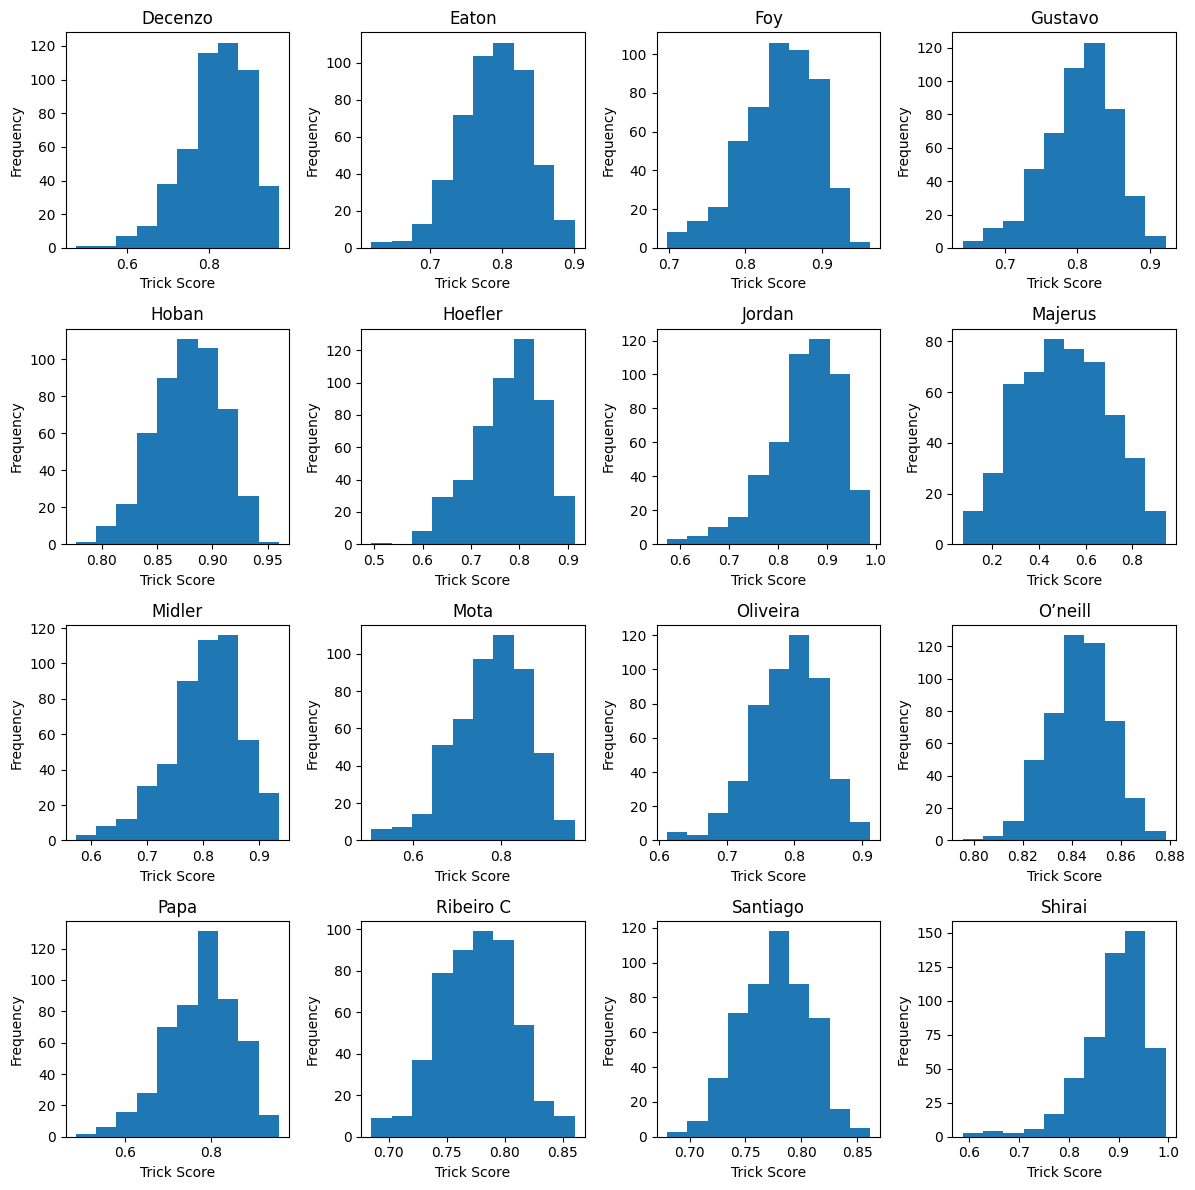

In [686]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array to iterate over it
axes = axes.flatten()

for index, row in results_df.iterrows():
    samps = np.random.beta(row['alpha_trick'], row['beta_trick'], size=500)
    
    # Get the current subplot
    ax = axes[index]
    
    # Plot the histogram on the current subplot
    ax.hist(samps)
    ax.set_title(row['id'])
    ax.set_xlabel('Trick Score')
    ax.set_ylabel('Frequency')

# Hide any remaining empty subplots
for i in range(len(results_df), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## (c) Propose a model for $Y_i$ and provide a point estimate for the parameters of your model. 

### Code

***Getting all runs for a unique ID.***

In [687]:
#Create all runs.
def aggregate_runs(runs):
    # This function aggregates the runs by filtering out zero values
    return list(runs[runs != 0])

# Assuming the runs are stored in columns named 'run1', 'run2', 'run3', etc.
run_columns = ['run 1', 'run 2']  # Add more columns if needed

# Group by 'id' and aggregate runs for each skateboarder
all_runs_df = df.melt(id_vars='id', value_vars=run_columns)\
                  .groupby('id')['value']\
                  .agg(aggregate_runs)\
                  .reset_index()

# Rename the columns for clarity
all_runs_df.columns = ['id', 'runs']

# Uncoment this to see the results.
# print(all_runs_df)



***Using the Gauss-Raphson method***

In [688]:
for index, row in all_runs_df.iterrows():
    samps = np.array(row['runs'])
    alpha_beta = Gauss_Raphson_method(samps)
    
    all_runs_df.at[index, 'alpha_run'] = round(alpha_beta[0],2)
    all_runs_df.at[index, 'beta_run'] = round(alpha_beta[1],2)

print(all_runs_df[['id', 'alpha_run', 'beta_run']])

           id  alpha_run  beta_run
0     Decenzo       3.91      2.66
1       Eaton      77.48     27.64
2         Foy       2.80      3.46
3     Gustavo       1.57      1.18
4       Hoban       3.63      2.09
5     Hoefler       1.41      1.02
6      Jordan       4.05      1.53
7     Majerus       1.68      2.48
8      Midler      28.00     22.08
9        Mota       3.61      3.91
10   Oliveira       4.62      3.41
11    O’neill       1.00      1.26
12       Papa       2.35      2.30
13  Ribeiro C       2.07      1.86
14   Santiago       2.47      4.00
15     Shirai       1.57      1.09


In [689]:
results_df['alpha_run'] = all_runs_df['alpha_run']
results_df['beta_run'] = all_runs_df['beta_run']

##### Graphical representation

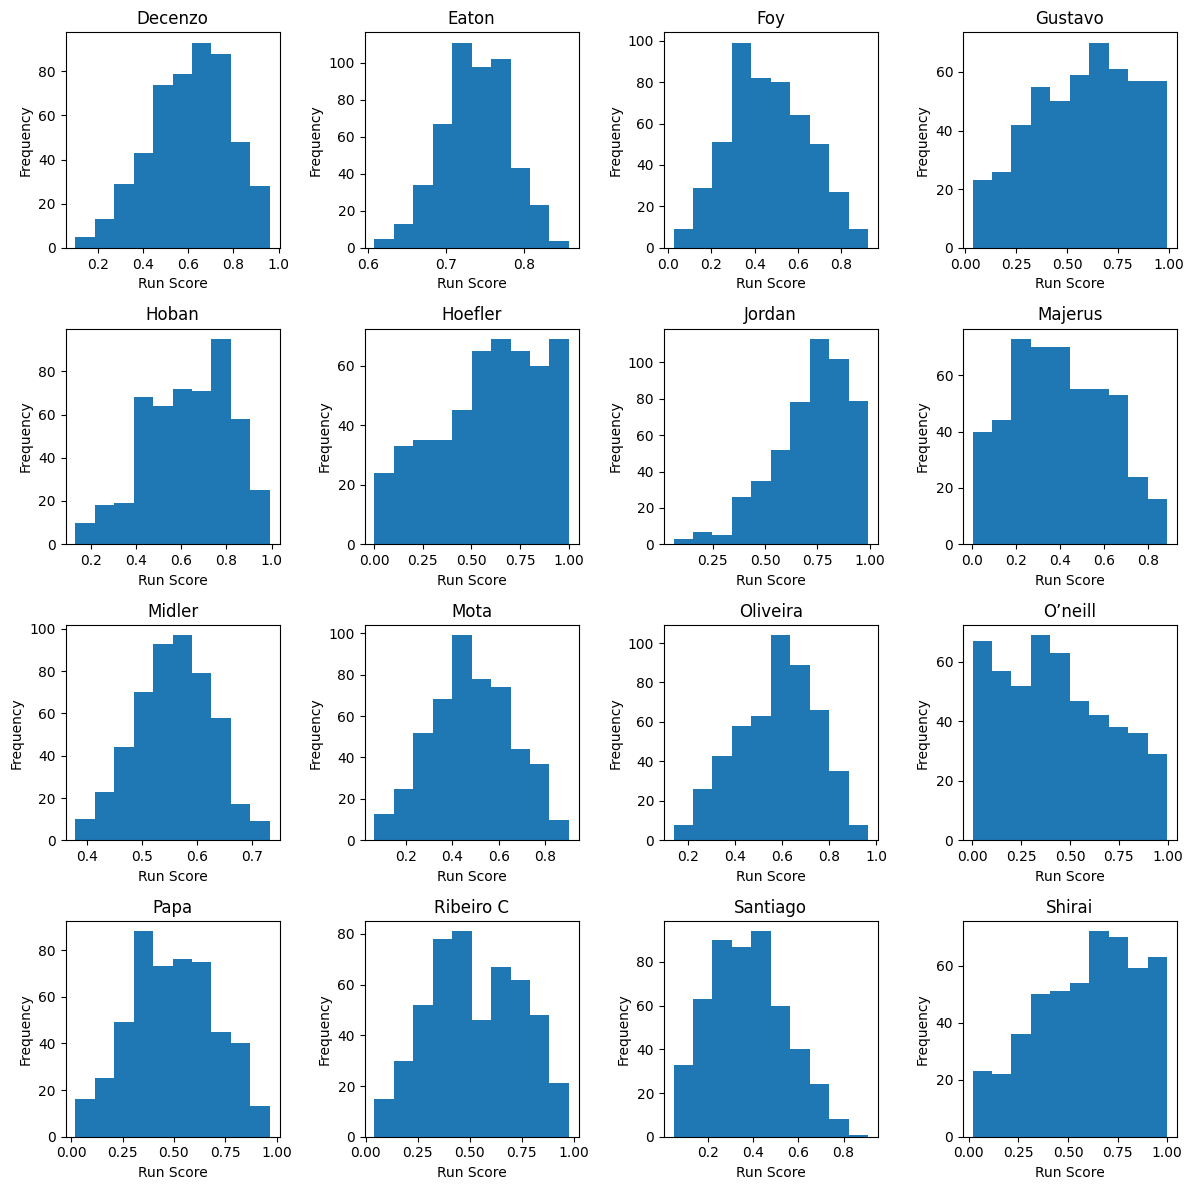

In [690]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array to iterate over it
axes = axes.flatten()

for index, row in results_df.iterrows():
    samps = np.random.beta(row['alpha_run'], row['beta_run'], size=500)
    
    # Get the current subplot
    ax = axes[index]
    
    # Plot the histogram on the current subplot
    ax.hist(samps)
    ax.set_title(row['id'])
    ax.set_xlabel('Run Score')
    ax.set_ylabel('Frequency')

# Hide any remaining empty subplots
for i in range(len(results_df), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## (d) Simulate LCQs

### Problem

Use your model for $[X_i, Y_i]^T$ to simulate $5000$ LCQs and for each simulation extract the four skateboarders $\mathbf{W} = [W_1, W_2, W_3, W_4]^T$ with the highest total scores. 
- What is the mode for $W_1, \ldots, W_{5000}$? 

The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 

- How many of the actual winners are predicted by the mode? 
- What is the estimated probability of the actual winners based on your simulations? 
- By the mode?

### Code

In [691]:
def successful_trick(theta):
    made=bool(np.random.binomial(1, theta))
    return made

In [692]:
def trick_score(alpha, beta):
    return stats.beta.rvs(alpha, beta, size=1)[0]

In [693]:
def run_score(alpha, beta):
    return stats.beta.rvs(alpha, beta, size=1)[0]

In [694]:
def total_score(trick_scores, run_scores):
    return max(run_scores) + sorted(trick_scores)[-1] + sorted(trick_scores)[-2]

In [695]:
def sort_my_df(new_lcq_df):
    sorted_df = new_lcq_df.sort_values(by='total score', ascending=False)
    return sorted_df

In [696]:
def simulate_lcq(results_df):
    new_lcq_df = pd.DataFrame(columns=["id", "run 1", "run 2", "trick 1", "trick 2", "trick 3", "trick 4"])
    
    for index, row in results_df.iterrows():
        
        theta_average=row['theta_average']
        alpha_trick=row['alpha_trick']
        beta_trick=row['beta_trick']    
        alpha_run=row['alpha_run']
        beta_run=row['beta_run']
        
        new_lcq_df.at[index, "id"]=row['id']
        
        for _ in range(4):
            if successful_trick(theta_average):
                trick=trick_score(alpha_trick, beta_trick)
            else:
                trick=0
            new_lcq_df.at[index, f"trick {_+1}"] = round(trick,1)
        
        for _ in range(2):
            run=run_score(alpha_run, beta_run)
            new_lcq_df.at[index, f"run {_+1}"] = round(run,1)
        
        total_score_value=total_score(new_lcq_df.loc[index, ['trick 1', 'trick 2', 'trick 3', 'trick 4']], new_lcq_df.loc[index, ['run 1', 'run 2']]) 
        new_lcq_df.at[index, "total score"]=round(total_score_value,1)
    
    return new_lcq_df

        

In [697]:
def find_top_four_skateboarders(new_lcq_df):
    return sort_my_df(new_lcq_df).head(4)

In [698]:
win_counts = {}

for _ in range(5000):
    top_four_df=find_top_four_skateboarders(simulate_lcq(results_df))
    winner_id = top_four_df.iloc[0]['id']
    win_counts[winner_id] = win_counts.get(winner_id, 0) + 1
    
df_win_counts = pd.DataFrame(list(win_counts.items()), columns=['id', 'win_count'])
df_ranked = df_win_counts.sort_values(by='win_count', ascending=False)

print(df_ranked)
    

KeyboardInterrupt: 

The actual winners for the LCQ are Gustavo, Hoban, Eaton, and Decenzo. 
- Look at Jordan and Shirai, figure out why?

# 3. Bayesian Model

## Problem Statment:
As an alternative to the frequentist model developed in Task 2, we can consider a Bayesian model.
$$
\Theta_i \perp A_i, B_i
$$
$$
f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right)=f_{\Theta_i}\left(\theta_i\right) f_{A_i, B_i}\left(\alpha_i, \beta_i\right)
$$

In [ ]:
#Get Data
initial_bayesian_df_tricks = all_tricks_df_with_zeroes.copy()[all_tricks_df_with_zeroes['id'].isin(skateboarders)]

initial_bayesian_df_tricks['theta_average'] = results_df['theta_average']
initial_bayesian_df_tricks['alpha_trick'] = results_df['alpha_trick']
initial_bayesian_df_tricks['beta_trick'] = results_df['beta_trick']

# Uncoment this to see the results.
#print(initial_bayesian_df_tricks)

### (a) 
Propose a joint prior distribution for the parameters $[\Theta_i, A_i, B_i]^T$ for $X_i$ where we assume $\Theta_i \perp A_i, B_i$ for all $i$. 


We know:
$$
X_i \mid \Theta_i=\theta_i, A_i=\alpha_i, B_i=\beta_i
$$


- $ \Theta_i$ represents the average value of a skateboarder landing a trick.
- $ A_i$ and $ B_i$ are parameters for a distribution that produces results between 0 and 1.

We are interested in the behavior or distribution of $ X_i$, the observed data for skateboarder $ i$, when the parameters $\Theta_i$, $ A_i$, and $ B_i$ are fixed at specific values.

1. **Prior for $\Theta_i$:** 
   
   - $\Theta_i$ represents the average value of a skateboarder landing a trick. 
   - Since $\Theta_i$ is an average value, it will lie between 0 and 1. 
   - A natural choice for a prior distribution for a parameter that lies between 0 and 1 is the Beta distribution since it is defined on the interval [0,1]. 
   
   If we use a non-informative prior,no strong beliefs about the distribution of $\Theta_i$ before observing the data. 
   A common choice, according to the notes, would be $Beta(1,1)$, which is equivalent to a uniform distribution on [0,1].
   
   Thus, $f_{\Theta_i}(\theta_i) = Beta(\theta_i; 1, 1)$=$U(0,1)$.

2. **Prior for $A_i$, $B_i$:** 
   
   - Since $A_i$, $B_i$ are are parameters for a distribution that produces results between 0 and 1, a natural choice for their prior distribution is the Beta distribution.

Given the above, the joint prior distribution for $\theta_i, A_i$, and $B_i$ is:
$$
f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right)=f_{\Theta_i}\left(\theta_i\right)  f_{A_i, B_i}\left(\alpha_i, \beta_i\right)
$$

Given the likelihood $f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)$, the posterior distribution is:
$$
f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)
$$
$$
f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i}\left(\theta_i\right)  f_{A_i, B_i}\left(\alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)
$$
We can use Metropolis Algorithm on this part: 

$$
f_{\Theta_i, A_i, B_i}\left(\theta_i, \alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(\mathbb{x} \mid \theta_i, \alpha_i, \beta_i\right)
$$

### (b) 
Generate 5000 random samples from the posterior distribution
$$
f_{\Theta_i, \alpha_i, \beta_i | \boldsymbol{X}_i}(\theta_i, \alpha_i, \beta_i | \boldsymbol{x}_i) .
$$
Plot your resulting samples for the marginal posterior distributions:
$$
f_{\theta_i | \boldsymbol{X}_i}(\theta_i | \boldsymbol{x}_i) \quad \text{and} \quad f_{\alpha_i, \beta_i | \boldsymbol{X}_i}(\alpha_i, \beta_i | \boldsymbol{x}_i) .
$$
Calculate the posterior sample mean and the posterior sample variance for each parameter $ \theta_i, \alpha_i $, and $ \beta_i $ for all skateboarders.

$$
f_{\Theta_i, A_i, B_i \mid \boldsymbol{X}_i}\left(\theta_i, \alpha_i, \beta_i \mid \boldsymbol{x}_i\right) \propto f_{\Theta_i}\left(\theta_i\right) f_{A_i, B_i}\left(\alpha_i, \beta_i\right) f_{\mathbb{X} \mid \Theta_i A_i, B_i}\left(x \mid \theta_i, \alpha_i, \beta_i\right)
$$

$$
f_{\Theta_i, A_i, B_i}(\theta_i, \alpha_i, \beta_i)=\left(\frac{1}{\bar{B}\left(\alpha_\theta, \beta_\theta\right)} \theta^{\alpha_\theta-1}(1-\theta)^{\beta_\theta-1}\right) \times(\alpha_i+\beta_i)^{-5 / 2}
$$

The likelihood is composed of two indicator functions $\mathbf{1}_{\boldsymbol{x}=\mathbf{0}}$ and $\mathbf{1}_{\boldsymbol{x}=\mathbf{1}}$, so we are going to have two posterior distributions: One where $x=0$ and one for $x>0$. 

- For $x>0$ we get: 

$$
f_{\Theta, A, B  \mid \boldsymbol{X}}(\theta, \alpha, \beta  \mid \boldsymbol{x})=\left(\frac{1}{B\left(\alpha_\theta, \beta_\theta\right)} \theta^{\alpha_\theta-1}(1-\theta)^{\beta_\theta-1}\right) (\alpha+\beta)^{-5 / 2} \left(\prod_{i=1}^n \theta  \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}\right)
$$

- The parameters $\alpha_\theta$ and $\beta_\theta$ are the hyperparameters of the Beta distribution for $\theta$, since I assume that $\theta$ is Beta($\theta_i$, 1, 1)=$U(0,1)$, this would mean $\alpha_\theta=1$ and $\beta_\theta=1$.
- In this part $(\alpha+\beta)^{-5 / 2}$, my initial guess for $\alpha$ and $\beta$ is by moment method for the whole population.
- In this part $\left(\prod_{i=1}^n \theta \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}\right)$, we use data from Part II.

***Initial guesses***
- The general initial guesses for parameters of apriori distributions can be taken via the moment method for the whole population.

In [ ]:
#Note: merged_tricks is a list of all tricks including 0s
merged_tricks_with_zeroes = [item for sublist in initial_bayesian_df_tricks['tricks'] for item in sublist]
print(merged_tricks_with_zeroes)
print("the length of merged_tricks is: ", len(merged_tricks_with_zeroes))

#Note: merged_tricks_without_zeroes is a list of all tricks without 0s
merged_tricks_without_zeroes=[x for x in merged_tricks_with_zeroes if x != 0]
print(merged_tricks_without_zeroes)
print("the length of merged_tricks_without_zeroes is: ", len(merged_tricks_without_zeroes))

initial_guess_trick_with_zeroes=get_moment_estimators(merged_tricks_with_zeroes)
inital_guess_tricks_without_zeroes=get_moment_estimators(merged_tricks_without_zeroes)

print(initial_guess_trick_with_zeroes)
print(inital_guess_tricks_without_zeroes)

[0.78, 0.86, 0.87, 0.0, 0.0, 0.0, 0.0, 0.86, 0.0, 0.78, 0.93, 0.71, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.84, 0.84, 0.77, 0.75, 0.0, 0.0, 0.8, 0.0, 0.79, 0.83, 0.9, 0.0, 0.88, 0.9, 0.0, 0.0, 0.0, 0.0, 0.83, 0.0, 0.77, 0.8, 0.8, 0.74, 0.0, 0.0, 0.0, 0.0, 0.83, 0.0, 0.88, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.91, 0.86, 0.86, 0.0, 0.92, 0.89, 0.88, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.73, 0.78, 0.67, 0.0, 0.0, 0.0, 0.0, 0.0, 0.78, 0.87, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.84, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88, 0.0, 0.9, 0.9, 0.0, 0.7, 0.88, 0.0, 0.0, 0.91, 0.79, 0.4, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.0, 0.79, 0.0, 0.0, 0.0, 0.73, 0.87, 0.0, 0.0, 0.0, 0.84, 0.0, 0.78, 0.0, 0.69, 0.0, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.71, 0.0, 0.82, 0.83, 0.8, 0.81, 0.0, 0.83, 0.85, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.72, 0.89, 0.73, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84, 0.0, 0.65, 0.8, 0.82, 0.0, 0.0, 0.0, 0.79, 0.8, 0.74, 

For $\theta \sim \operatorname{Beta}(1,1)$, the log PDF is:
$$
\log f_{\Theta_i}\left(\theta_i\right)=\log \left(\frac{\Gamma(1+1)}{\Gamma(1) \Gamma(1)} \theta_i^{1-1}\left(1-\theta_i\right)^{1-1}\right)
$$
Since $\Gamma(1)=1$, the log PDF simplifies to:
$$
\log f_{\Theta_i}\left(\theta_i\right)=\log \left(\theta_i\right)+\log \left(1-\theta_i\right)
$$

In [ ]:
# Herre theta should come from uniform distribution [0,1] ???
def log_prior_theta(theta):
    return np.log(theta) + np.log(1 - theta)

$$(\alpha+\beta)^{-5 / 2}$$
$$
-\frac{5}{2} \log (\alpha+\beta)
$$

In [ ]:
# The parameters you send here are the moment estimators for the whole population.
#There is no need for parameters here since we are using moment estimators
def log_prior_alpha_beta(alpha, beta):
    return -5 / 2 * np.log(alpha + beta)


$$
\log \left(\theta_i\right)+\log \left(1-\theta_i\right) -\frac{5}{2} \log (\alpha+\beta)
$$

In [ ]:
# The parameters you send here are the moment estimators for the whole populatio.
def log_prior(alpha, beta, theta):
    return log_prior_alpha_beta(alpha, beta) + log_prior_theta(theta)

$$
\prod_{i=1}^n \theta \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}
$$
$$
\sum_{i=1}^n \log \left(\theta \frac{1}{B\left(\alpha_i, \beta_i\right)} z_i^{\alpha_i-1}\left(1-z_i\right)^{\beta_i-1}\right)
$$
$$
\sum_{i=1}^n\left(\log (\theta)+\log \left(\frac{1}{B\left(\alpha_i, \beta_i\right)}\right)+\log \left(z_i^{\alpha_i-1}\right)+\log \left(\left(1-z_i\right)^{\beta_i-1}\right)\right)
$$
$$
\sum_{i=1}^n \log (\theta)+\sum_{i=1}^n \log \left(\frac{1}{B\left(\alpha_i, \beta_i\right)}\right)+\sum_{i=1}^n \log \left(z_i^{\alpha_i-1}\right)+\sum_{i=1}^n \log \left(\left(1-z_i\right)^{\beta_i-1}\right)
$$
$$
n \log (\theta)+\left(\sum_{i=1}^n \log \left(\frac{1}{B\left(\alpha_i, \beta_i\right)}\right)\right)+\left(\sum_{i=1}^n\left(\alpha_i-1\right) \log \left(z_i\right)\right) +\left(\sum_{i=1}^n\left(\beta_i-1\right) \log \left(1-z_i\right)\right)
$$

- Since  $\theta_i$, $\alpha_i$ and $\beta_i$ are the same for each contestant and only $z_i$ changes we can write: 
$$
n \log (\theta)+\left(\sum_{i=1}^n \log \left(\frac{1}{B\left(\alpha, \beta\right)}\right)\right)+\left(\sum_{i=1}^n\left(\alpha-1\right) \log \left(z_i\right)\right)+\left(\sum_{i=1}^n\left(\beta-1\right) \log \left(1-z_i\right)\right)
$$

In [ ]:
#The parameters you send here are from part-II.
def log_likelihood(alpha, beta, theta, data):
    n = len(data)
    
    n_log_theta = n * np.log(theta)
    
    second_part = 0
    for trick in data:
        if trick !=0:
            second_part += np.log(1/stats.beta(alpha, beta))
        
    third_part = 0
    for trick in data:
        if trick !=0:
            third_part += (alpha-1)*np.log(trick)
    
    forth_part = 0
    for trick in data:
        if trick !=0:
            forth_part += (beta-1)*np.log(1-trick)
        
    return n_log_theta + second_part + third_part + forth_part

In [ ]:
# Log posterior
#def log_posterior(alpha, beta, theta, data):
#   return log_prior(alpha, beta, theta) + log_likelihood(alpha, beta, theta, data)

<iframe width="560" height="315" src="https://www.youtube.com/embed/0F0QoMCSKJ4?si=w7JY36TpygsHr_r2" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/OTO1DygELpY?si=o--yk03nV36-5p7o" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/0lpT-yveuIA?si=i_yIc54L-IBub6tV" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In [ ]:
#Lets just test if it works for one skateboarder...Decenzo

condition = initial_bayesian_df_tricks['id'] == 'Decenzo'
selected_row = initial_bayesian_df_tricks[condition]
theta_average_data = selected_row['theta_average'].iloc[0]
alpha_trick_data = selected_row['alpha_trick'].iloc[0]
beta_trick_data = selected_row['beta_trick'].iloc[0]
data = selected_row['tricks'].iloc[0]
alpha_guess = initial_guess_trick_with_zeroes[0]
beta_guess = initial_guess_trick_with_zeroes[1]

# Metropolis algorithm
delta = 0.1
k = 8000
params = [np.exp(stats.cauchy.rvs(size=3))]  # Now we have three parameters: alpha, beta, theta

for _ in range(k - 1):
    last = params[-1]
    
    log_last = np.log(last)
    log_proposal = log_last + delta * stats.norm.rvs(size=3)
    proposal = np.exp(log_proposal)
    
    r = np.exp(log_posterior(*proposal, data) - log_posterior(*last, data))
    
    u = stats.uniform.rvs()
    
    if u < min(1, r):
        params.append(proposal)
    else:
        params.append(last)

params = np.array(params)

NameError: name 'log_posterior' is not defined

In [ ]:
# Plotting the marginal posterior distributions
plt.figure(figsize=(10, 6))
plt.hist(params[:, 0], bins=50, density=True, alpha=0.6, label=r"$\alpha_i$")
plt.hist(params[:, 1], bins=50, density=True, alpha=0.6, label=r"$\beta_i$")
plt.hist(params[:, 2], bins=50, density=True, alpha=0.6, label=r"$\theta_i$")
plt.legend()
plt.show()

In [ ]:
# Calculate the posterior sample mean and variance
alpha_mean = np.mean(params[:, 0])
alpha_var = np.var(params[:, 0])

In [ ]:
beta_mean = np.mean(params[:, 1])
beta_var = np.var(params[:, 1])


In [ ]:
theta_mean = np.mean(params[:, 2])
theta_var = np.var(params[:, 2])

In [ ]:
print(f"Alpha: Mean = {alpha_mean}, Variance = {alpha_var}")
print(f"Beta: Mean = {beta_mean}, Variance = {beta_var}")
print(f"Theta: Mean = {theta_mean}, Variance = {theta_var}")

Answer

### (c) 
- Propose a (joint) prior distribution for the parameters of your model $Y_i$ from task $2(c)$ and justify your choice. 

- You can assume that the model's parameters for skateboarder $i$ are independent of all other parameters including $\theta_i$, $\alpha_i$, and $\beta_i$. 

- Generate 5000 samples from the posterior distribution (make sure to save these samples!) and create a scatter plot of the results. 

- What is the sample mean and sample variance for each of your parameters based on your outcomes?

In [ ]:
#Code

Answer

### (d) 
Use your Bayesian model for $[X_i, Y_i]^T$ to simulate 5000 LCQs by drawing samples from the appropriate posterior predictive distributions. 

- What is the mode of your outcomes $W_1, \ldots, W_{5000}$? 

- How many of the real winners are predicted? 

- What is the estimated probability of the real winners based on your samples? 

- And by the mode?

In [ ]:
#Code

Answer

### (e) 
In the model in task $3(\mathrm{d})$, we assumed that the parameters $\Upsilon_i$ for $Y_i$ and the parameters $\Theta_i = [\Theta_i, A_i, B_i]^T$ for $X_i$ are independent given the data. 

- Why?

Answer

At the same time, we did not assume that $\Theta_i \perp A_i, B_i$ are independent given the data. 

1. Let $X_i^{(1)}, X_i^{(2)}, X_i^{(3)}, X_i^{(4)}$ denote skateboarder $i$'s four trick scores.
2. Let $Y_i^{(1)}, Y_i^{(2)}$ denote skateboarder $i$'s two run scores.
3. Let $O_i$ denote their total score. 

- Draw a directed acyclic graph with as few edges as possible so that the joint distribution of $O_i, X_i^{(1)}, X_i^{(2)}, X_i^{(3)}, X_i^{(4)}, Y_i^{(1)}, Y_i^{(2)}, \Theta_i, A_i, B_i$ and $\Upsilon$ is Markov with respect to it. 

Answer


- Based on your graph, can you conclude that the marginal posterior distribution for $\Theta_i, A_i$, and $B_i$ factorizes as:
$$
f_{\theta_i, \alpha_i, \beta_i | \boldsymbol{X}_i}(\theta_i, \alpha_i, \beta_i | \boldsymbol{x}_i) = f_{\theta_i | \boldsymbol{X}_i}(\theta_i | \boldsymbol{x}_i) f_{\alpha_i, \beta_i | \boldsymbol{X}_i}(\alpha_i, \beta_i | \boldsymbol{x}_i) ?
$$

Answer


Consider your parameters $\Upsilon_i$ for $Y_i$ and the parameters $\Theta_i$ for $X_i$. 

- According to your graph, is the following assumption reasonable?

$$
\Upsilon_i \perp \Theta_i | X_i^{(1)}, X_i^{(2)}, X_i^{(3)}, X_i^{(4)}, Y_i^{(1)}, Y_i^{(2)}
$$

Answer

- Can we assume the independence relation $\Upsilon_i \perp \Theta_i | O_i$ if only the data $o_i$ is given instead?

In [ ]:
#Code

Answer

# 4. A Bayesian model with a hierarchy
To account for possible variations in skateboarders' performances between different competitions, we can build a model that uses a hierarchy. As we saw in the lectures, we can build a Bayesian hierarchy for $V_i \sim \operatorname{Ber}(\theta_i)$ if we group outcomes $v_i$ according to the different competitions. For simplicity, we use our frequentist point estimates for the parameters $\alpha_i, \beta_i$ and the parameters for $Y_i$ from task 2.

### (a) 
Assume that $\Theta_i \mid A_i=\alpha_i, B_i=\beta_i \sim \operatorname{Beta}(\alpha_i, \beta_i)$ and choose a suitable simultaneous prior distribution for $\left[\Theta_i, A_i, B_i\right]^T$. 

- Justify your choice.

Answer

### (b) 

Generate 5000 random outcomes from the simultaneous posterior distribution
$$
f_{A_i, B_i \mid \boldsymbol{X}_i}(a_i, b_i \mid \boldsymbol{x}_i) .
$$

In [ ]:
#Code

Use your simulations to generate 5000 random outcomes from the marginal posterior distribution $\Theta_i \mid \boldsymbol{X}_i=\boldsymbol{x}_i$.

In [ ]:
#Code

Plot your outcomes for the following posterior distributions:
$$
f_{\theta_i \mid \boldsymbol{X}_i}(\theta_i \mid \boldsymbol{x}_i) \quad \text{and} \quad f_{A_i, B_i \mid \boldsymbol{X}_i}(a_i, b_i \mid \boldsymbol{x}_i) ,
$$

In [ ]:
#Code

Provide estimates for the posterior expected value and posterior variance for each of the parameters. 

- How do these variances for $\theta_i$ compare to the variances for $\theta_i$ computed for the model in Task 3?

Answer

### (c) 
Using your $5000$ samples from part (b), simulate 5000 LCQ competition winners and calculate the mode of the results. 

- What are the respective estimated probabilities for the actual winners and your mode value?

In [ ]:
# Code

Answer

# 5. Discussion 
It is always important to reflect on our model assumptions when conducting statistical inference. Specifically, it is important to assess how the models can be improved.

### (a) 

- How do the results (the skateboarders in the typical values) from the different models compare? 

- Which skateboarders are correctly predicted and which are not? 

- Provide some possible explanations for the differences between the predictions of the different models. 

- Which model do you prefer and why?

Answer

### (b) 

- How do your estimates for $\theta_i$ in Assignment 1 compare to your estimated expected values and variances for $\theta_i$ in Assignments 3 and 4? 

- What is the expected score for a trick for each skateboarder given that the trick has been successfully landed? What is the expected run score? 

- Considering the skateboarders who are predicted to win according to the different models, do these statistics provide any insights into successful strategies for winning? 

- For example, does it work to focus on a good run score over good trick scores? 

- Are there instances where this strategy works? 

- Is it better to have higher trick scores with high variance or slightly worse trick scores with less variance? etc.

Answer

### (c) 

- Estimate the expected value and standard deviation for each skateboarder's total score for the models in Assignments 3 and 4. 

- Do these statistics support your predictions? 

- According to these statistics, what needs to occur for the outcome to be the actual winners?

Answer

### (d) 

- In all the models, we assumed that the skateboarder's performances are independent. For example, we assumed that all $V_i$ are independent. 

- Does this seem like a reasonable assumption? Justify your answer.

Answer

### (e) 

- In all the models, we ignored the order in which the skateboarders took turns. Does this seem like a reasonable thing to do? 

- Why or why not?

Answer